In [3]:
################################################################################ 0. Import the library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from google.colab import drive                                                  
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import Input
from keras.utils import to_categorical
from scipy.stats import ttest_ind
from sklearn import svm, linear_model, metrics
sns.set(style="darkgrid", color_codes=True)

np.random.seed(20201005)                                                        # For reproducibility

In [4]:
################################################################################ PART I: Exploratory Data Analysis and Data Cleaning
                                                                                # 1. Loading the dataset: SENT_GROUP_INFO and SENT_RATING_DATA
drive.mount('/gdrive', force_remount=True)                                      # Mount the files at the google colab

sg_index = "B:E,AE:AI,CW:DJ,DM,FN"                                              # Select the dataset based on the column

s_grp_dir = '/gdrive/My Drive/SCAN_seminar_data/SENT_GROUP_INFO.xlsx'           # Load the dataset SENT_GROUP_INFO only "B:E,AE:AI,CW:DJ,DM,FN"
s_group = pd.read_excel(s_grp_dir, usecols = sg_index)
s_rat_dir = '/gdrive/My Drive/SCAN_seminar_data/SENT_RATING_DATA.xlsx'          # Load the dataset: SENT_RATING_DATA
s_rating = pd.read_excel(s_rat_dir)

Mounted at /gdrive


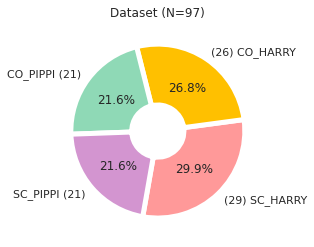

In [5]:
################################################################################ 2. Exploratory Data Analysis: Coherent ENG+GER, HARRY AND PIPPI
                                                                                # SENT_GROUP_INFO.xlsx
sg_harry = s_group['TEXT'] == 'HARRY'                                           # return true only for HARRY
sg_pippi = s_group['TEXT'] == 'PIPPI'                                           # return true only for PIPPI
sg_coherent = s_group['CONDITION'] == 'COHERENT'                                # return true only for COHERENT
sg_scrambled = s_group['CONDITION'] == 'SCRAMBLED'                              # return true only for SCRAMBLED
sg_eng = s_group['QESTN_LANGUAGE'] == 'ENG'                                     # return true only for ENG
sg_ger = s_group['QESTN_LANGUAGE'] == 'GER'                                     # return true only for GER
                                                                                # SENT_RATING_DATA.xlsx
sr_harry = s_rating['TEXT'] == 'HARRY'                                          # retrun true only for HARRY
sr_pippi = s_rating['TEXT'] == 'PIPPI'                                          # retrun true only for PIPPI
sr_coherent = s_rating['CONDITION'] == 'COHERENT'                               # retrun true only for COHERENT
sr_scrambled = s_rating['CONDITION'] == 'SCRAMBLED'                             # retrun true only for SCRAMBLED
sr_eng = s_rating['LANGUAGE'] == 'ENG'                                          # retrun true only for ENG
sr_ger = s_rating['LANGUAGE'] == 'GER'                                          # retrun true only for GER

                                                                                # Data filtering in the certain conditions
sg_co_harry = s_group[sg_harry & sg_coherent]                                   # HARRY and COHERENT
sg_sc_harry = s_group[sg_harry & sg_scrambled]                                  # HARRY and SCRAMBLED
sg_co_pippi = s_group[sg_pippi & sg_coherent]                                   # PIPPI and COHERENT
sg_sc_pippi = s_group[sg_pippi & sg_scrambled]                                  # PIPPI and SCRAMBLED

categories = ['(29) SC_HARRY','(26) CO_HARRY','CO_PIPPI (21)','SC_PIPPI (21)']  # Plot the distribution of the whole dataset (N=97)
sizes = [len(sg_sc_harry),len(sg_co_harry),len(sg_sc_pippi),len(sg_sc_pippi)]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=260,
       colors=colors,wedgeprops=wedgeprops)
plt.title('Dataset (N=97)')
plt.show()

bad data case list: [9, 19, 48, 84, 96, 87]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


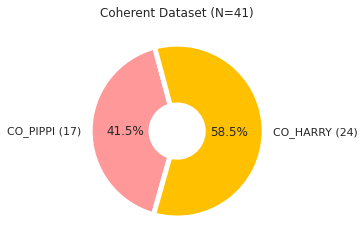

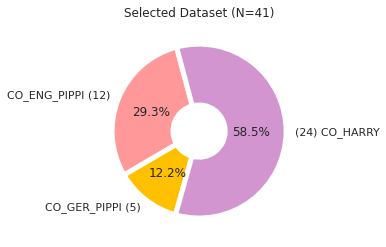

In [6]:
################################################################################ 3. Data Cleaning: Exclude the bad data with visualization
sg_co = s_group[sg_coherent]
sr_co = s_rating[sr_coherent]
                                                                                # Create the Bad data list
b_DEG = sg_co.loc[sg_co['DEG_TIME']>100]['CASE']                                # DEG_TIME > 100, bad data
b_ATT = sg_co.loc[sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS']>0]['CASE']      # ATTENTION_CHECKS_COUNT_WRONG_ANSWERS > 0, bad data
b_PAG = sr_co.loc[sr_co['PAGE_TIME']>999]['CASE']                               # PAGE_TIME > 999, bad data

b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)                             # Concatenate the bad data

b_list = b_list.drop_duplicates()                                               # Delete the duplicates
b_case = list(b_list.values)                                                    # Convert bad data's case as a list
print('bad data case list:',b_case)
                                                                                
a_group = sg_co.copy()                                                          # Copy the SENT_GROUP_INFO.coherent
a_rating = sr_co.copy()                                                         # Copy the # SENT_RATING_DATA.coherent

for i in b_case:                                                                # Excluded the bad case from the coherent dataset
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)

sg_co_harry = a_group[sg_harry & sg_coherent]                                   # HARRY and COHERENT
sg_sc_harry = a_group[sg_harry & sg_scrambled]                                  # HARRY and SCRAMBLED
sg_co_pippi = a_group[sg_pippi & sg_coherent]                                   # PIPPI and COHERENT
sg_sc_pippi = a_group[sg_pippi & sg_scrambled]                                  # PIPPI and SCRAMBLED
sg_co_en_pippi = a_group[sg_pippi & sg_coherent & sg_eng]
sg_co_ge_pippi = a_group[sg_pippi & sg_coherent & sg_ger]

categories = ['CO_PIPPI (17)','CO_HARRY (24)']                                  # Plot the distribution of the COHERENT dataset (N=41)
sizes = [len(sg_co_pippi),len(sg_co_harry)]
colors = ['#ff9999', '#ffc000']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=105,
       colors=colors,wedgeprops=wedgeprops)
plt.title('Coherent Dataset (N=41)')                                            # print(len(sg_co_pippi))
plt.show()                                                                      # print(len(sg_co_harry))


categories = ['CO_ENG_PIPPI (12)','CO_GER_PIPPI (5)','(24) CO_HARRY']           # Plot the distribution of the dataset (N=41)
sizes = [len(sg_co_en_pippi),len(sg_co_ge_pippi),len(sg_co_harry)]
colors = ['#ff9999', '#ffc000','#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=105,                # print(len(sg_co_harry))
       colors=colors,wedgeprops=wedgeprops)                                     # print(len(sg_co_pippi))
plt.title('Selected Dataset (N=41)')                                            # print(len(sg_co_en_pippi))
plt.show()                                                                      # print(len(sg_co_ge_pippi))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


HARRY
CASE              0
AROUSAL_RATING    0
VALENCE_RATING    0
dtype: int64 NaN
PIPPI
CASE              0
AROUSAL_RATING    0
VALENCE_RATING    0
dtype: int64 NaN
Coherent demographic informations: 
            CASE  ...   DEG_TIME
count  24.000000  ...  24.000000
mean   39.916667  ...  12.625000
std    24.313025  ...  11.948485
min     3.000000  ...   0.000000
25%     9.500000  ...   6.000000
50%    52.500000  ...   9.000000
75%    58.250000  ...  14.500000
max    64.000000  ...  45.000000

[8 rows x 22 columns]
              CASE    PAGE_TIME  ...  AROUSAL_RATING  VALENCE_RATING
count  3000.000000  3000.000000  ...     3000.000000     3000.000000
mean     39.916667    18.652667  ...        3.129333        4.545333
std      23.805082    26.659175  ...        0.923521        1.340601
min       3.000000     2.000000  ...        1.000000        1.000000
25%       9.500000     8.000000  ...        3.000000        4.000000
50%      52.500000    11.000000  ...        3.000000        4.00

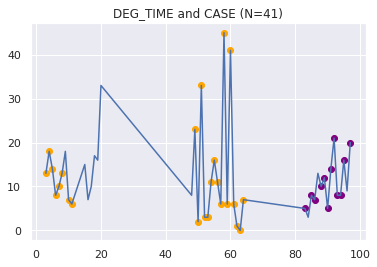

b_DEG []


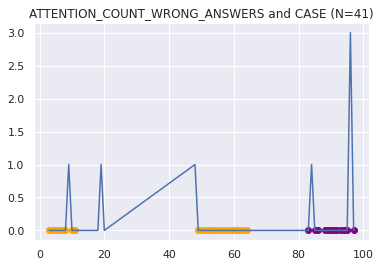

b_ATT [9, 19, 48, 84, 96]


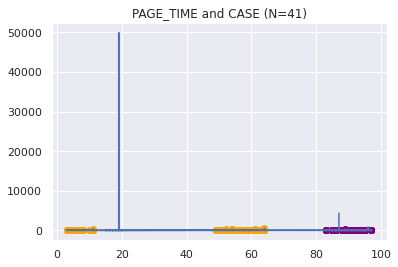

b_PAG [19, 19, 19, 87]


In [7]:
################################################################################ Set the using only coherent dataset
ar_co_harry = a_rating[sr_harry & sr_coherent]                                  # HARRY and COHERENT in SENT_RATING_DATA
ar_co_pippi = a_rating[sr_pippi & sr_coherent & sr_eng]                         # PIPPI and COHERENT and ENG in SENT_RATING_DATA
ag_co_harry = a_group[sg_harry & sg_coherent]                                   # HARRY and COHERENT in SENT_GROUP_INFO
ag_co_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                          # PIPPI and COHERENT and ENG in SENT_GROUP_INFO

################################################################################ drop out the NaN column in PIPPI
gh = ag_co_harry                                                                # HARRY AND COHERENT in SENT_GROUP_INFO
gp = ag_co_pippi                                                                # PIPPI AND COHERENT in SENT_GROUP_INFO

rh = ar_co_harry.loc[:,['CASE','AROUSAL_RATING','VALENCE_RATING']]              # HARRY AND COHERENT in SENT_RATING_DATA
rp = ar_co_pippi.loc[:,['CASE','AROUSAL_RATING','VALENCE_RATING']]              # PIPPI AND COHERENT in SENT_RAITING_DATA
rp = rp.dropna(axis=0)                                                          # drop out NaN row
print('HARRY')
print(rh.isnull().sum(), 'NaN')                                                 # check the NaN
print('PIPPI')
print(rp.isnull().sum(), 'NaN')                                                 # check the NaN

print("Coherent demographic informations: ")                                    # Demographic info on the countable columns
print(ag_co_harry.describe())
print(ar_co_harry.describe())

################################################################################ Additional Plots
plt.title('DEG_TIME and CASE (N=41)')                                           # Plot the DEG_TIME
plt.scatter(ag_co_harry['CASE'], ag_co_harry['DEG_TIME'], c='orange')
plt.scatter(ag_co_pippi['CASE'], ag_co_pippi['DEG_TIME'], c='purple')
plt.plot(sg_co['CASE'], sg_co['DEG_TIME'])
plt.show()
print('b_DEG', list(b_DEG))                                                     # Print the case of DEG_TIME

plt.title('ATTENTION_COUNT_WRONG_ANSWERS and CASE (N=41)')                      # Plot the ATTENTION_COUNT_WRONG_ANSWERS
plt.scatter(ag_co_harry['CASE'],ag_co_harry['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'],c='orange')
plt.scatter(ag_co_pippi['CASE'],ag_co_pippi['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'],c='purple')
plt.plot(sg_co['CASE'],sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'])
plt.show()
print('b_ATT', list(b_ATT))                                                     # Print the case of ATTENTION_CHECKS_COUNT_WRONG_ANSWERS

plt.title('PAGE_TIME and CASE (N=41)')                                          # Plot the PAGE_TIME
plt.scatter(ar_co_harry['CASE'], ar_co_harry['PAGE_TIME'], c='orange')
plt.scatter(ar_co_pippi['CASE'], ar_co_pippi['PAGE_TIME'], c='purple')
plt.plot(sr_co['CASE'], sr_co['PAGE_TIME'])
plt.show()
print('b_PAG', list(b_PAG))                                                     # Print the case of PAGE_TIME

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


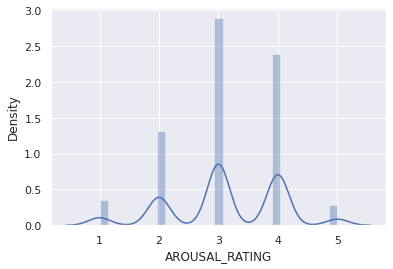

In [8]:
################################################################################ AROUSAL_RATING and VALENCE_RATING HARRY distribution
s_rating_filtered = rh.filter(["VALENCE_RATING", "AROUSAL_RATING"])
sns.distplot(s_rating_filtered["AROUSAL_RATING"])                               # AROUSAL_RATING in HARRY

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


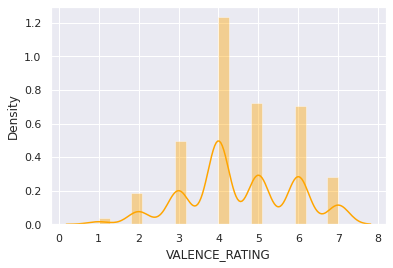

In [9]:
sns.distplot(s_rating_filtered['VALENCE_RATING'], color='orange')               # VALENCE_RATING

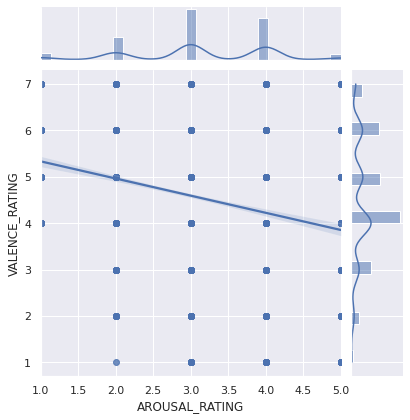

In [10]:
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',                            # Joint plot of the both VALENCE_RATING and AROUSAL_RATING in HARRY
              data = s_rating_filtered,kind='reg')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


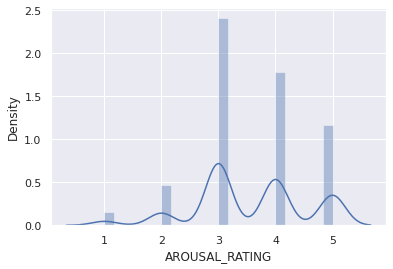

In [11]:
################################################################################ AROUSAL_RATING and VALENCE_RATING PIPPI distribution
s_rating_filtered = rp.filter(["VALENCE_RATING", "AROUSAL_RATING"])
sns.distplot(s_rating_filtered["AROUSAL_RATING"])                               # AROUSAL_RATING in PIPPI

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


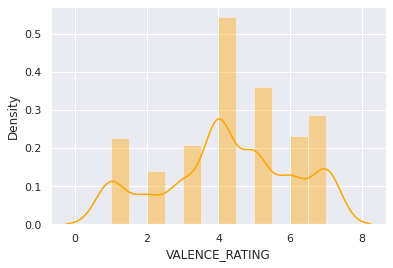

In [12]:
sns.distplot(s_rating_filtered['VALENCE_RATING'], color='orange')               # VALENCEL_RATING in PIPPI

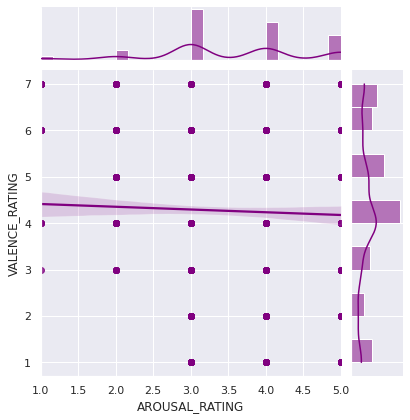

In [13]:
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',                            # Joint plot of the both VALENCE_RATING and AROUSAL_RATING in PIPPI
              data = s_rating_filtered,kind='reg',color ='purple')

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13  5.000000
3      4  HARRY  ...       18  4.309524
4      5  HARRY  ...       14  2.833333
5      6  HARRY  ...        8  4.357143
6      7  HARRY  ...       10  4.404762
7      8  HARRY  ...       13  5.357143
9     10  HARRY  ...        7  4.214286
10    11  HARRY  ...        6  3.261905
48    49  HARRY  ...       23  2.357143
49    50  HARRY  ...        2  4.190476

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


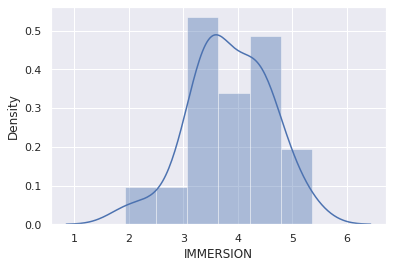

In [14]:
################################################################################ PART II: Design the dependent variable, level of immersion
rg_set = pd.concat([gh,gp], axis = 0)                                           # Merge the HARRY and PIPPI dataset
a_group = rg_set.copy()                                                         # Copy the dataset
h_group = gh.copy()
p_group = gp.copy()

a_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'

reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    a_group['IMMERSION'] += a_group.iloc[:,i]

a_group['IMMERSION']=a_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(a_group.head(10))
sns.distplot(a_group["IMMERSION"])
                                                                                ## !!! Alternative:
                                                                                ## Calculate the immersion as a geometric mean
                                                                                ## Function for geometric mean:
                                                                                #def geo_mean(x):
                                                                                #   a = np.array(x)
                                                                                #   return a.prod()**(1.0/len(a))   

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13  5.000000
3      4  HARRY  ...       18  4.309524
4      5  HARRY  ...       14  2.833333
5      6  HARRY  ...        8  4.357143
6      7  HARRY  ...       10  4.404762
7      8  HARRY  ...       13  5.357143
9     10  HARRY  ...        7  4.214286
10    11  HARRY  ...        6  3.261905
48    49  HARRY  ...       23  2.357143
49    50  HARRY  ...        2  4.190476

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


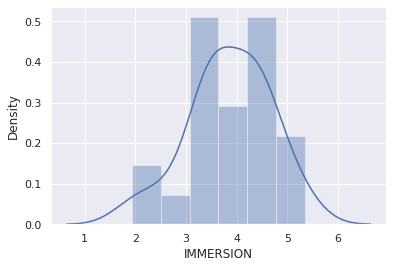

In [15]:
h_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'

reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    h_group['IMMERSION'] += h_group.iloc[:,i]

h_group['IMMERSION']=h_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(h_group.head(10))
sns.distplot(h_group["IMMERSION"])

    CASE   TEXT  ... DEG_TIME IMMERSION
82    83  PIPPI  ...        5  4.880952
84    85  PIPPI  ...        8  3.142857
85    86  PIPPI  ...        7  3.690476
87    88  PIPPI  ...       10  4.357143
88    89  PIPPI  ...       12  3.047619
89    90  PIPPI  ...        5  4.476190
90    91  PIPPI  ...       14  4.285714
91    92  PIPPI  ...       21  3.880952
92    93  PIPPI  ...        8  3.357143
93    94  PIPPI  ...        8  3.547619

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


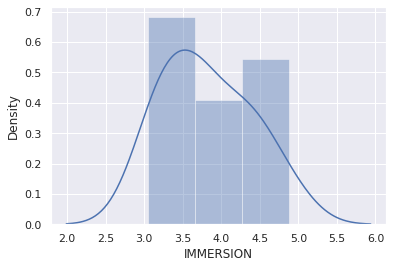

In [16]:
p_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'

reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    p_group['IMMERSION'] += p_group.iloc[:,i]

p_group['IMMERSION']=p_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(p_group.head(10))
sns.distplot(p_group["IMMERSION"])   

In [17]:
################################################################################ PART III: Statistical Analysis Immersion with other variable
e_group = a_group.copy()
e_group.head()

#e_group = h_group.copy()
#e_group.head()

#e_group = p_group.copy()
#e_group.head()

,CASE,TEXT,CONDITION,QESTN_LANGUAGE,BFI_EXTRAVERSION,BFI_AGREEABLENESS,BFI_CONSCIENTIOUSNESS,BFI_NEUROTICISM,BFI_OPENNESS,FOCUSING_OF_ATTENTION,TEXT_ABSORPTION,IMAGINABILITY,SPATIAL_INVOLVEMENT,RECEPTION_TERMINATION,SUSPENSE,EMOTIONAL_INVOLVEMENT,GENERAL_READING_ENJOYMENT,IDENTIFICATION,PARASOCIAL_INTERACTION,COGNITIVE_INVOLVEMENT,THEMATIC_INTEREST,ANALYTICAL_RECEPTION,EASE_OF_COGNITIVE_ACCESS,ATTENTION_CHECKS_COUNT_WRONG_ANSWERS,DEG_TIME,IMMERSION
2,3,HARRY,COHERENT,GER,3.5,3.0,4.0,2.5,4.0,5.5,4.5,6.0,4.0,4.5,5.5,6.0,6.0,5.75,6,6.0,6.0,3.000000,5.5,0,13,5.000000
3,4,HARRY,COHERENT,GER,3.5,3.0,3.0,3.0,4.5,3.5,3.5,5.5,3.5,2.5,3.5,5.0,4.5,4.75,4,3.0,5.0,3.666667,5.0,0,18,4.309524
4,5,HARRY,COHERENT,GER,3.5,2.5,3.5,4.5,2.5,3.5,1.5,2.0,1.5,3.0,2.0,3.5,2.5,3.25,1,2.5,1.0,4.333333,1.0,0,14,2.833333
5,6,HARRY,COHERENT,GER,4.5,4.0,5.0,2.5,5.0,5.0,2.5,4.5,3.5,3.0,5.0,5.5,5.0,3.50,3,4.0,5.0,3.000000,4.5,0,8,4.357143
6,7,HARRY,COHERENT,GER,5.0,3.5,4.5,4.0,4.5,4.0,3.5,3.5,5.5,3.5,5.0,6.0,6.0,5.50,5,3.0,5.0,3.333333,4.0,0,10,4.404762


BFI_EXTRAVERSION
R2:  0.16705374576096987
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     6.819
Date:                Wed, 30 Sep 2020   Prob (F-statistic):             0.0133
Time:                        18:22:02   Log-Likelihood:                -36.226
No. Observations:                  36   AIC:                             76.45
Df Residuals:                      34   BIC:                             79.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

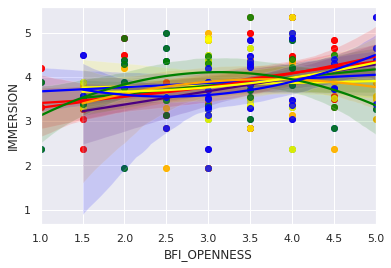

In [18]:
################################################################################ 1.Statistical Analysises between Immersion and 5 BFI: Mean case
                                                                                # Using linear regression, oridnary least square
bfi_list = []
for i in range(5):
    bfi_list.append(e_group.columns[i+4])

def immersion_bfi_sa(bfi_list):                                                 # Function for the Statistical Analysis
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):                                                 # Function for the Plot the IMMERSION and BFI in linear regression
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):                                                # Function for the Plot the IMMERSION and BFI in nonlinear regression
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group,
                    color = color[i], order = 2)

immersion_bfi_sa(bfi_list)                                                      # Statistical Analysis
immersion_bfi_pl(bfi_list)                                                      # Plot the IMMERSION and BFI in linear regression
immersion_bfi_pl2(bfi_list)                                                     # Plot the IMMERSION and BFI in nonlinear regression

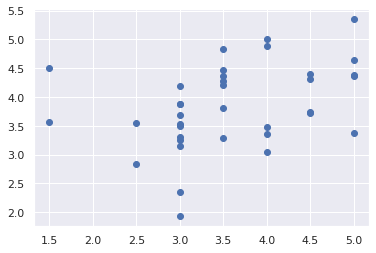

In [19]:
################################################################################2. BFI_OPENNESS and IMMERSION distribution
x = e_group['BFI_OPENNESS']                                                     # BFI_OPENNESS and IMMERSION
y = e_group['IMMERSION']
plt.scatter(x,y)

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.501
Date:                Wed, 30 Sep 2020   Prob (F-statistic):             0.0250
Time:                        18:22:04   Log-Likelihood:                -36.817
No. Observations:                  36   AIC:                             77.63
Df Residuals:                      34   BIC:                             80.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7703      0.473  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


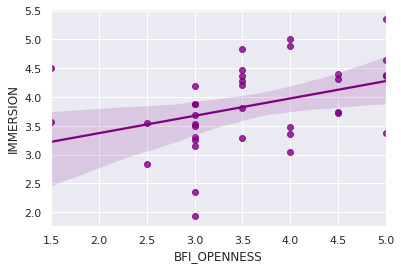

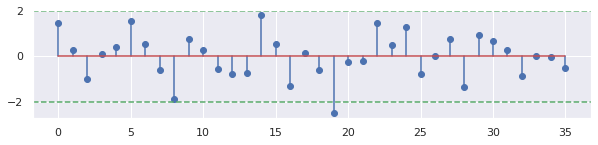

In [20]:
################################################################################ IMMERSION and BFI OPENNESS
res = smf.ols(formula='IMMERSION ~ BFI_OPENNESS', data = e_group).fit()         # Using linear regression, oridnary least square
sns.regplot(x="BFI_OPENNESS", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

BFI_OPENESS


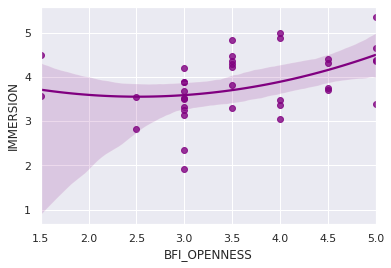

In [21]:
################################################################################ IMMERSION AND BFI OPENNESS
                                                                                # Plot the non-linear
sns.regplot(x="BFI_OPENNESS", y="IMMERSION",
            data = e_group, order = 2, color = 'purple')
print('BFI_OPENESS')

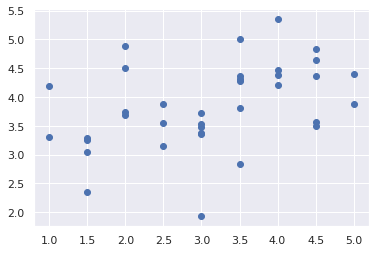

In [22]:
################################################################################ 3.BFI_EXTRAVERSION and IMMERSION
x = e_group['BFI_EXTRAVERSION']                                                 # BFI_EXTRAVERSION and IMMERSION distribution
y = e_group['IMMERSION']
plt.scatter(x,y)

BFI_EXTRAVERSION
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     6.819
Date:                Wed, 30 Sep 2020   Prob (F-statistic):             0.0133
Time:                        18:22:06   Log-Likelihood:                -36.226
No. Observations:                  36   AIC:                             76.45
Df Residuals:                      34   BIC:                             79.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


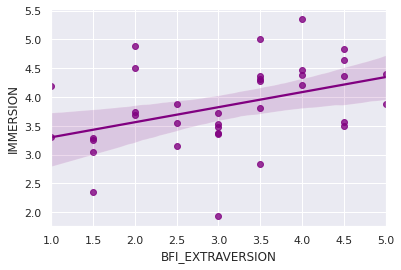

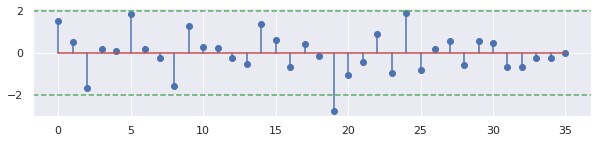

In [23]:
################################################################################ IMMERSION AND BFI_EXTRAVERSION
                                                                                # Using linear regression, oridnary least square
res = smf.ols(formula='IMMERSION ~ BFI_EXTRAVERSION', data = e_group).fit()
sns.regplot(x="BFI_EXTRAVERSION", y="IMMERSION", data=e_group, color='purple')
print('BFI_EXTRAVERSION')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

BFI_EXTRAVERSION


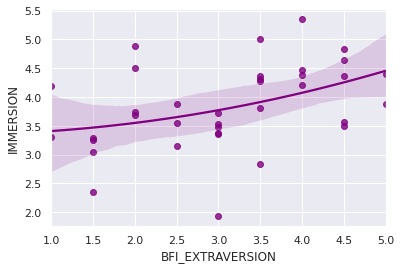

In [24]:
################################################################################ IMMERSION AND BFI_EXTRAVERSION
                                                                                # Plot the non-linear
sns.regplot(x="BFI_EXTRAVERSION", y="IMMERSION",
            data = a_group, order = 2, color = 'purple')
print('BFI_EXTRAVERSION')

In [25]:
################################################################################ PART IV: Model based data analysis
                                                                                # 1. Preprocess the dataset
gh_case = list(a_group.loc[a_group['TEXT']=='HARRY'].loc[:,['CASE']]['CASE'])   # HARRY CASE LIST "print(len(gh_case))"
gp_case = list(a_group.loc[a_group['TEXT']=='PIPPI'].loc[:,['CASE']]['CASE'])   # PIPPI CASE LIST "#print(len(gp_case))"

tr_hr_case = gh_case[2:22]                                                      
te_hr_case = gh_case[0:2] + gh_case[22:25]
hr_case = [tr_hr_case, te_hr_case]                                              # HARRY case

tr_pi_case = gp_case[0:10]
te_pi_case = gp_case[10:14]
pi_case = [tr_pi_case, te_pi_case]                                              # PIPPI case

################################################################################ Load the independent variable related dataset
rh_set = rh.copy()
rp_set = rp.copy()

hr_train_arousal = []
hr_train_valence = []
hr_test_arousal = []
hr_test_valence = []

for i in hr_case:                                                               # HARRY
    for j in i:                                                                 # Extract both Arousal and Valence
        if i == tr_hr_case:
            set = rh_set[rh_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            hr_train_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            hr_train_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rh_set[rh_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            hr_test_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            hr_test_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

pi_train_arousal = []
pi_train_valence = []
pi_test_arousal = []
pi_test_valence = []

for i in pi_case:                                                               # PIPPI
    for j in i:                                                                 # Extract both Arousal and Valence
        if i == tr_pi_case:
            set = rp_set[rp_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            pi_train_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            pi_train_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rp_set[rp_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            pi_test_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            pi_test_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

print('Coherent HARRY Dataset')                                                 # Set the both x_Train, and x_Test
print('train_arousal:',len(hr_train_arousal),hr_train_arousal)
print('train_valence:',len(hr_train_valence),hr_train_valence)
print('test_arousal:',len(hr_test_arousal),hr_test_arousal)
print('test_valence:',len(hr_test_valence),hr_test_valence)

print('Coherent PIPPI Dataset')
print('train_arousal:',len(pi_train_arousal),pi_train_arousal)
print('train_valence:',len(pi_train_valence),pi_train_valence)
print('test_arousal:',len(pi_test_arousal),pi_test_arousal)
print('test_valence:',len(pi_test_valence),pi_test_valence)

Coherent HARRY Dataset
train_arousal: 20 [[5.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0], [4.0, 4.0, 4.0, 2.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 1.0, 4.0, 3.0, 5.0, 5.0, 4.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 4.0, 2.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 

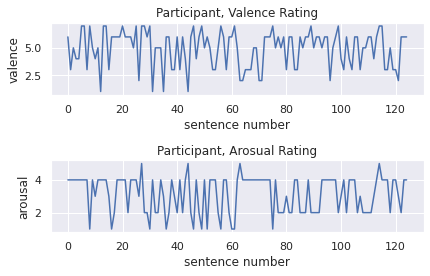

In [26]:
################################################################################ Plot the valence and arousal data
t = hr_train_valence[4]
s = hr_train_arousal[4]

plt.subplot(2, 1, 1)                                                            # VALENCE_RATING
plt.plot(t)
plt.xlabel('sentence number')
plt.ylabel('valence')
plt.title('Participant, Valence Rating')
plt.grid(True)

plt.subplot(2, 1, 2)                                                            # AROUSAL_RATING
plt.plot(s)
plt.title('Participant, Arosual Rating')
plt.xlabel('sentence number')
plt.ylabel('arousal')
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
################################################################################ Set the both Y_Train, and Y_Test
hr_train_immersion = []
hr_test_immersion = []

for i in hr_case:                                                               # HARRY IMMERSION DATASET
    for j in i:
        if i == tr_hr_case:
            hr_train_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))
        else:
            hr_test_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))

print('hr_train_immersion',len(hr_train_immersion),hr_train_immersion)
print('hr_test_immersion',len(hr_test_immersion),hr_test_immersion)

# PIPPI IMMERSION DATASET
pi_train_immersion = []
pi_test_immersion = []

for i in pi_case:                                                               # PIPPI IMMERSION DATASET
    for j in i:
        if i == tr_pi_case:
            pi_train_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))
        else:
            pi_test_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))

print('pi_train_immersion',len(pi_train_immersion),pi_train_immersion)
print('pi_test_immersion',len(pi_test_immersion),pi_test_immersion)

hr_train_immersion 20 [[2.833333333333333], [4.357142857142857], [4.404761904761904], [5.357142857142857], [4.214285714285714], [3.261904761904762], [2.357142857142857], [4.190476190476191], [3.880952380952381], [3.738095238095238], [3.2857142857142856], [3.476190476190476], [4.5], [4.642857142857143], [3.380952380952381], [4.380952380952381], [3.7142857142857144], [1.9285714285714286], [3.5], [3.523809523809524]]
hr_test_immersion 4 [[5.0], [4.309523809523809], [4.833333333333334], [3.5714285714285716]]
pi_train_immersion 10 [[4.8809523809523805], [3.142857142857143], [3.6904761904761902], [4.357142857142857], [3.0476190476190474], [4.476190476190476], [4.285714285714286], [3.880952380952381], [3.357142857142857], [3.5476190476190474]]
pi_test_immersion 2 [[3.8095238095238098], [3.3095238095238098]]


In [28]:
################################################################################ Dataset as np.array
print('HARRY Dataset')                                                          # HARRY DATASET
hr_tr_arousal = np.array(hr_train_arousal)
hr_tr_valence = np.array(hr_train_valence)
hr_tr_immersion = np.array(hr_train_immersion)

hr_te_arousal = np.array(hr_test_arousal)
hr_te_valence = np.array(hr_test_valence)
hr_te_immersion = np.array(hr_test_immersion)

print('HARRY Training set')                                                     
print('hr_tr_arousal',hr_tr_arousal.shape,hr_tr_arousal)
print('hr_tr_valence',hr_tr_valence.shape,hr_tr_valence)
print('hr_tr_immersion',hr_tr_immersion.shape,hr_tr_immersion)

print('HARRY Test set')
print(hr_te_arousal)
print(hr_te_valence)
print(hr_te_immersion)

print('PIPPI Dataset')                                                          # PIPPI DATASET
pi_tr_arousal = np.array(pi_train_arousal)
pi_tr_valence = np.array(pi_train_valence)
pi_tr_immersion = np.array(pi_train_immersion)

pi_te_arousal = np.array(pi_test_arousal)
pi_te_valence = np.array(pi_test_valence)
pi_te_immersion = np.array(pi_test_immersion)

print('PIPPI Training set')
print('pi_tr_arousal',pi_tr_arousal.shape,pi_tr_arousal)
print('pi_tr_valence',pi_tr_valence.shape,pi_tr_valence)
print('pi_tr_immersion',pi_tr_immersion.shape,pi_tr_immersion)

print('PIPPI Test set')
print(pi_te_arousal)
print(pi_te_valence)
print(pi_te_immersion)

HARRY Dataset
HARRY Training set
hr_tr_arousal (20, 125) [[5. 4. 3. ... 2. 2. 2.]
 [4. 4. 4. ... 3. 4. 5.]
 [5. 4. 4. ... 4. 4. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 4. 5. ... 2. 2. 3.]
 [4. 4. 5. ... 3. 3. 2.]]
hr_tr_valence (20, 125) [[1. 2. 4. ... 5. 5. 6.]
 [5. 3. 5. ... 4. 4. 6.]
 [5. 5. 4. ... 5. 6. 7.]
 ...
 [4. 4. 3. ... 4. 4. 4.]
 [6. 6. 7. ... 6. 7. 6.]
 [6. 2. 7. ... 4. 4. 5.]]
hr_tr_immersion (20, 1) [[2.83333333]
 [4.35714286]
 [4.4047619 ]
 [5.35714286]
 [4.21428571]
 [3.26190476]
 [2.35714286]
 [4.19047619]
 [3.88095238]
 [3.73809524]
 [3.28571429]
 [3.47619048]
 [4.5       ]
 [4.64285714]
 [3.38095238]
 [4.38095238]
 [3.71428571]
 [1.92857143]
 [3.5       ]
 [3.52380952]]
HARRY Test set
[[4. 2. 1. 1. 1. 3. 4. 4. 2. 3. 3. 2. 4. 4. 3. 2. 2. 2. 2. 2. 4. 2. 1. 4.
  2. 2. 3. 2. 4. 3. 3. 2. 3. 2. 3. 2. 1. 4. 5. 4. 4. 2. 3. 3. 5. 1. 4. 3.
  4. 4. 2. 2. 1. 2. 2. 2. 2. 2. 4. 1. 3. 2. 4. 4. 4. 4. 5. 2. 2. 3. 4. 4.
  5. 2. 1. 3. 2. 1. 4. 4. 4. 2. 1. 4. 4. 2. 2. 1. 3. 1. 4. 3. 3. 

In [29]:
################################################################################ Concatenate to design flatten (2,) dataset
print(hr_tr_arousal.shape)                                                      # HARRY DATATSET
print(hr_tr_valence.shape)
print(hr_te_arousal.shape)
print(hr_te_valence.shape)
hr_tr_dataset = np.stack([hr_tr_arousal, hr_tr_valence], axis=0)
hr_te_dataset = np.stack([hr_te_arousal, hr_te_valence], axis=0)

print(hr_tr_dataset.shape)
print(hr_te_dataset.shape)

print(pi_tr_arousal.shape)                                                      # PIPPI DATASET
print(pi_tr_valence.shape)
print(pi_te_arousal.shape)
print(pi_te_valence.shape)
pi_tr_dataset = np.stack([pi_tr_arousal, pi_tr_valence], axis=0)
pi_te_dataset = np.stack([pi_te_arousal, pi_te_valence], axis=0)

print(pi_tr_dataset.shape)
print(pi_te_dataset.shape)

(20, 125)
(20, 125)
(4, 125)
(4, 125)
(2, 20, 125)
(2, 4, 125)
(10, 133)
(10, 133)
(2, 133)
(2, 133)
(2, 10, 133)
(2, 2, 133)


In [30]:
################################################################################ Concatenate to design flatten (1,) dataset
hr_tr_dataset = np.concatenate((hr_tr_arousal, hr_tr_valence), axis = 1)
hr_te_dataset = np.concatenate((hr_te_arousal, hr_te_valence), axis = 1)
print(hr_tr_dataset.shape,'tr_dataset')
print(hr_tr_dataset)
print(hr_te_dataset.shape,'te_dataset')
print(hr_te_dataset)
pi_tr_dataset = np.concatenate((pi_tr_arousal, pi_tr_valence), axis = 1)
pi_te_dataset = np.concatenate((pi_te_arousal, pi_te_valence), axis = 1)

(20, 250) tr_dataset
[[5. 4. 3. ... 5. 5. 6.]
 [4. 4. 4. ... 4. 4. 6.]
 [5. 4. 4. ... 5. 6. 7.]
 ...
 [3. 3. 3. ... 4. 4. 4.]
 [3. 4. 5. ... 6. 7. 6.]
 [4. 4. 5. ... 4. 4. 5.]]
(4, 250) te_dataset
[[4. 2. 1. 1. 1. 3. 4. 4. 2. 3. 3. 2. 4. 4. 3. 2. 2. 2. 2. 2. 4. 2. 1. 4.
  2. 2. 3. 2. 4. 3. 3. 2. 3. 2. 3. 2. 1. 4. 5. 4. 4. 2. 3. 3. 5. 1. 4. 3.
  4. 4. 2. 2. 1. 2. 2. 2. 2. 2. 4. 1. 3. 2. 4. 4. 4. 4. 5. 2. 2. 3. 4. 4.
  5. 2. 1. 3. 2. 1. 4. 4. 4. 2. 1. 4. 4. 2. 2. 1. 3. 1. 4. 3. 3. 4. 3. 4.
  4. 4. 2. 4. 3. 4. 2. 3. 4. 4. 4. 1. 2. 2. 3. 1. 1. 4. 4. 4. 4. 4. 2. 4.
  4. 3. 2. 1. 4. 5. 6. 6. 7. 7. 7. 7. 7. 7. 6. 3. 4. 4. 5. 7. 6. 6. 6. 6.
  5. 6. 6. 7. 3. 5. 7. 4. 7. 5. 6. 6. 3. 5. 7. 4. 2. 4. 5. 5. 3. 4. 5. 4.
  4. 3. 6. 7. 4. 5. 7. 6. 5. 4. 5. 5. 5. 5. 6. 4. 6. 6. 6. 5. 6. 3. 3. 3.
  4. 5. 4. 2. 3. 5. 7. 7. 7. 6. 7. 5. 6. 6. 6. 7. 3. 3. 5. 6. 7. 4. 7. 4.
  5. 3. 4. 4. 3. 2. 3. 5. 5. 4. 3. 3. 4. 5. 5. 5. 6. 5. 5. 7. 7. 7. 5. 6.
  7. 6. 3. 6. 3. 3. 6. 6. 7. 4.]
 [4. 4. 4. 3. 3. 4. 4. 4. 3. 3

In [31]:
################################################################################ 2. Linear Regression for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)


test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

1/1 [==============================] - 0s 1ms/step - loss: 2.5516 - mae: 1.2607
expected_value 5.888786792755127 	 real_value [5.]
expected_value 3.5573203563690186 	 real_value [4.30952381]
expected_value 1.8945858478546143 	 real_value [4.83333333]
expected_value 4.034682273864746 	 real_value [3.57142857]


In [32]:
################################################################################ 3. Non-linear Regression for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)


test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

1/1 [==============================] - 0s 1ms/step - loss: 1.4161 - mae: 1.0348
expected_value 5.561638832092285 	 real_value [5.]
expected_value 5.478145599365234 	 real_value [4.30952381]
expected_value 5.302417278289795 	 real_value [4.83333333]
expected_value 5.511355400085449 	 real_value [3.57142857]


In [33]:
################################################################################ 4. SVR, Support Vector Regressor for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(x_train,y_train)

y_pred = SupportVectorRegModel.predict(x_test)

for i, e in enumerate(y_pred):
    #print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])
    print(y_pred[i], y_test[i])

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(rmse)

4.075174721322965 [5.]
3.6891555302285663 [4.30952381]
3.8263092280321263 [4.83333333]
4.004486027528646 [3.57142857]
0.7813121826417019


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
################################################################################ 5. XGB Regressor for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

predict = xgb_grid.predict(x_test)
for i, e in enumerate(predict):
    print("expected_value",predict[i], '\t', "real_value", y_test[i])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    6.3s finished


0.5226940037607117
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
expected_value 4.174108 	 real_value [5.]
expected_value 3.860819 	 real_value [4.30952381]
expected_value 3.6903903 	 real_value [4.83333333]
expected_value 4.127695 	 real_value [3.57142857]


In [35]:
################################################################################ 6. NN, simple one for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)


test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

1/1 [==============================] - 0s 1ms/step - loss: 0.6205 - mae: 0.7345
expected_value 4.155217170715332 	 real_value [5.]
expected_value 3.6368045806884766 	 real_value [4.30952381]
expected_value 3.731353521347046 	 real_value [4.83333333]
expected_value 3.8898305892944336 	 real_value [3.57142857]


In [36]:
################################################################################ 7. Linear Regression for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)


test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

1/1 [==============================] - 0s 1ms/step - loss: 0.3418 - mae: 0.5792
expected_value 4.467916011810303 	 real_value [3.80952381]
expected_value 3.8096184730529785 	 real_value [3.30952381]


In [37]:
################################################################################ 8. Non-linear Regression for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)


test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

1/1 [==============================] - 0s 5ms/step - loss: 6.6619 - mae: 2.5689
expected_value 0.9905935525894165 	 real_value [3.80952381]
expected_value 0.9905935525894165 	 real_value [3.30952381]


In [38]:
################################################################################ 9. SVR, Support Vector Regressor for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(x_train,y_train)

y_pred = SupportVectorRegModel.predict(x_test)

for i, e in enumerate(y_pred):
    #print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])
    print(y_pred[i], y_test[i])

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(rmse)

4.002810825184541 [3.80952381]
4.0215969600261605 [3.30952381]
0.5217317519997108


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
################################################################################ 10. XGB Regressor for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

predict = xgb_grid.predict(x_test)
for i, e in enumerate(predict):
    print("expected_value",predict[i], '\t', "real_value", y_test[i])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


-0.0438040157754116
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
expected_value 4.299824 	 real_value [3.80952381]
expected_value 4.0067163 	 real_value [3.30952381]


[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    2.6s finished


In [40]:
################################################################################ 11. NN, simple one for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

1/1 [==============================] - 0s 2ms/step - loss: 2.7886 - mae: 1.5784
expected_value 4.842639923095703 	 real_value [3.80952381]
expected_value 5.4331464767456055 	 real_value [3.30952381]


In [107]:
################################################################################ 12. Nueral network, Regression: Grid Search, Hyper-parameter tuning for HARRY
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.core import Dense, Dropout, Activation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

def gridsearch_model(dropout_rate,neurons,neurons2):
    """
    This function for building a gridsearch_model,
    dropout_rate : float, 0 to 1 normally 0.1, 0.3, 0.5 etc.
    neurons : integer, first dropout layer parameter.
    neurons2 : integer, second dropout layer parameter.

    returns a model.
    """  
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation = 'relu'))    
    model.add(Dense(neurons2,activation = 'relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model
model = KerasRegressor(build_fn=gridsearch_model, nb_epoch=100, batch_size=4, verbose=0)

# Gridsearch on hyper parameters
dropout_rate = [0.1,0.5]
neurons = [32,64]
neurons2 = [16,64]

param_grid = dict(dropout_rate = dropout_rate, neurons = neurons,
                  neurons2 = neurons2)
grid = GridSearchCV(estimator = model, param_grid = param_grid,n_jobs=-1)
grid_result = grid.fit(x_train,y_train)

# Summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean,stdev,param in zip(means,stds,params):
    print("%f (%f) with: %r" % (mean,stdev,param))
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

-2.431802 (2.563797) with: {'dropout_rate': 0.1, 'neurons': 32, 'neurons2': 16}
-1.013514 (0.736004) with: {'dropout_rate': 0.1, 'neurons': 32, 'neurons2': 64}
-1.415807 (0.850718) with: {'dropout_rate': 0.1, 'neurons': 64, 'neurons2': 16}
-1.322144 (0.612693) with: {'dropout_rate': 0.1, 'neurons': 64, 'neurons2': 64}
-4.763964 (2.166049) with: {'dropout_rate': 0.5, 'neurons': 32, 'neurons2': 16}
-2.848390 (2.197030) with: {'dropout_rate': 0.5, 'neurons': 32, 'neurons2': 64}
-2.350033 (2.358970) with: {'dropout_rate': 0.5, 'neurons': 64, 'neurons2': 16}
-3.853675 (5.542364) with: {'dropout_rate': 0.5, 'neurons': 64, 'neurons2': 64}
Best: -1.013514 using {'dropout_rate': 0.1, 'neurons': 32, 'neurons2': 64}


0.1
32
64
[0.1, 32, 64]
processing fold #: 1
processing fold #: 2
processing fold #: 3
processing fold #: 4
processing fold #: 5


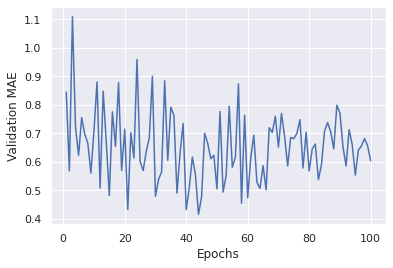

1/1 [==============================] - 0s 1ms/step - loss: 0.4798 - mae: 0.6637
expected_value 4.233498573303223 	 real_value [5.]
expected_value 3.9275670051574707 	 real_value [4.30952381]
expected_value 3.920299768447876 	 real_value [4.83333333]
expected_value 4.164913654327393 	 real_value [3.57142857]


In [108]:
################################################################################ 12. Nueral network, Regression: Cross Validation for HARRY
para = grid_result.best_params_
append = []
list = ['dropout_rate','neurons','neurons2']
for i in list:
    print(para[i])
    append.append(para[i])
print(append)

k = 5                                                                           # K-fold cross-validation
num_val_samples = len(x_train) // k
num_epochs = 100
all_mae_scores = []

def build_model():                                                              # Define the model
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(Dropout(append[0]))
    model.add(layers.Dense(append[1], activation='relu'))
    model.add(layers.Dense(append[2], activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

for i in range(k):
    print('processing fold #:', i+1)
    val_data = x_train[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]

    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
         axis=0)

    model = build_model()
    history = model.fit(partial_x_train, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=4, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_scores.append(mae_history)
    # val_mse, val_mae = model.evaluate(val_data, val_targets, vebose=0)
    # all_scores.append(val_mae)

average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)             # Validation MAE Visualization
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

model = build_model()                                                           # Final model
model.fit(x_train, y_train,
          epochs=50, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

In [111]:
################################################################################ 12. Nueral network, Regression: Cross Validation for HARRY
para = grid_result.best_params_
append = []
list = ['dropout_rate','neurons','neurons2']
for i in list:
    print(para[i])
    append.append(para[i])
print(append)

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(Dropout(append[0]))
model.add(layers.Dense(append[1], activation='relu'))
model.add(layers.Dense(append[2], activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train,y_train,epochs=40,batch_size=40,verbose=0)

test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

0.1
32
64
[0.1, 32, 64]
1/1 [==============================] - 0s 1ms/step - loss: 0.6330 - mae: 0.7604
expected_value 4.581547260284424 	 real_value [5.]
expected_value 3.2907536029815674 	 real_value [4.30952381]
expected_value 4.158045291900635 	 real_value [4.83333333]
expected_value 4.500365734100342 	 real_value [3.57142857]
